In [2]:
import pandas as pd
import numpy as np
import random
import math
import scipy
from scipy import stats

from sklearn.preprocessing import StandardScaler  # for feature scaling
from sklearn.model_selection import train_test_split  # for train/test split
import matplotlib.pyplot as plt  #For representation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import l1_min_c  # for L1 regluarization path

# Example code for calculating accuracy, precision, recall, and F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
#from statkit.decision import net_benefit
from statkit.decision import net_benefit
from scipy import integrate


import dca_fs_tools as dcat
import dca_fs as dcafs

import torch
import copy

# Initialize

Define funtions

### Synthetic data

In [3]:
# Initialise sklearn LR (used for comparison)

logreg = LogisticRegression()

### Torch LR functions

In [3]:
#"""  Create a dataset
#===================#
"""
n_sample = 100000

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0], heteros=0.0) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#-------------------------
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 32)

lda = cs[-1]
lda = 1./(lda)
lda = lda/n_sample
#lda = 0.9*lda

#test_reg = reg_lr_train(df_noisy_train, n_epochs=4000, learn_rate = .001, loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0], lambda_reg=lda )

#test_reg = reg_lr_train(df_noisy_train, 
#                        n_epochs=1000, 
#                        learn_rate = 0.01,
#                        history_size= 100,
#                        max_iter= 100,
#                        tolerance_grad=1e-8,
#                        tolerance_change=1e-10,
#                        loss_fun = 'log', 
#                        regularization_type = 'L1', 
#                        weights = [1.0, 1.0, 1.0], 
#                        lambda_reg=lda )

test_reg = reg_lr_train(df_noisy_train, 
                        n_epochs=1000, 
                        learn_rate = 0.001,
                        #history_size= 1000,
                        #max_iter= 1000,
                        tolerance_grad=1e-8,
                        tolerance_change=1e-10,
                        loss_fun = 'log', 
                        regularization_type = 'L1', 
                        weights = [1.0, 1.0, 1.0], 
                        lambda_reg=lda )

plt.plot(np.arange(len(test_reg['loss'][1:])), test_reg['loss'][1:], "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show() """

'\nn_sample = 100000\n\ndf_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs =     make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [3, 2.5, -2.0], heteros=0.0) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])\n#-------------------------\ncs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 32)\n\nlda = cs[-1]\nlda = 1./(lda)\nlda = lda/n_sample\n#lda = 0.9*lda\n\n#test_reg = reg_lr_train(df_noisy_train, n_epochs=4000, learn_rate = .001, loss_fun = \'log\', regularization_type = \'L1\', weights = [1.0, 1.0, 1.0], lambda_reg=lda )\n\n#test_reg = reg_lr_train(df_noisy_train, \n#                        n_epochs=1000, \n#                        learn_rate = 0.01,\n#                        history_size= 100,\n#                        max_iter= 100,\n#                        tolerance_grad=1e-8,\n#                        tolerance_change=1e-10,\n#                        loss_fun = \'log\', \n#            

## Test Torch LR

### Agreement of LR parameters

In [3]:
# Create a dataset
#===================#
n_sample = 100000

df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=0.) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

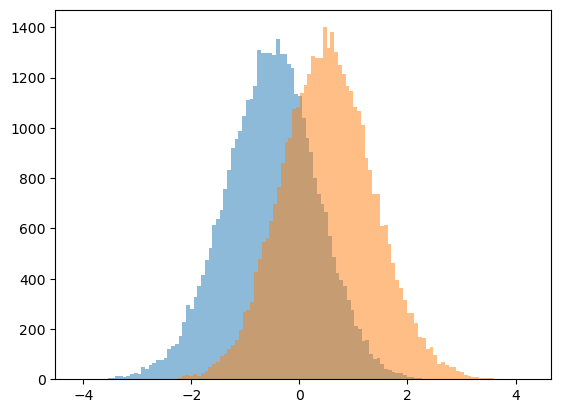

In [ ]:
# Visualize synthetic data set
#================================#

x1 = df_train.loc[df_train.y==0]['x0']
x2 = df_train.loc[df_train.y==1]['x0']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, label='0')
plt.hist(x2, **kwargs, label='1')
plt.show()


#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
#plt.legend();

In [5]:
# Fit a logistic regression with sklearn
#==========================================#

logreg.fit(df_train[ind_var_names], df_train["y"])

print(logreg.coef_)
#print(logreg.n_features_in_)

[[ 1.7166198   0.80803705 -0.40478191]]


In [7]:
list(df_train.drop(["y"], axis = 1).columns)

['x0', 'x1', 'x2']

In [6]:
# Fit with torch implementation
#================================#

test_run = dcafs.lr_train(df_train, n_epochs=1000, learn_rate=  1.0, loss_fun = 'log')
#test_run = lr_train(df_train, n_epochs=20000, learn_rate=  0.001, save_name_mod = "", loss_fun = 'mnb')

test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs

(Parameter containing:
 tensor([[ 1.7169,  0.8082, -0.4049]], requires_grad=True),
 Parameter containing:
 tensor([0.0050], requires_grad=True),
 [1.7, 0.8, -0.4])

Parameter containing:
tensor([[ 1.7174,  0.7849, -0.4021]], requires_grad=True) Parameter containing:
tensor([0.0012], requires_grad=True) [1.7, 0.8, -0.4]


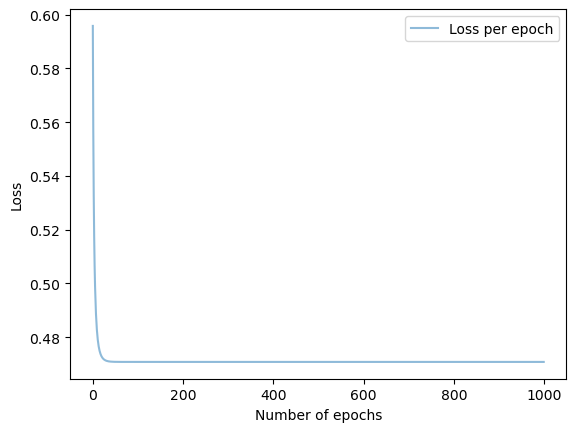

In [9]:
# Fit with torch implementation - mnb loss
#================================#

test_run_mnb = dcafs.lr_train(df_train, n_epochs=500, learn_rate=  1.0, loss_fun = 'mnb')
#test_run = reg_lr_train_legacy(df_train, n_epochs=100, learn_rate=  0.1, save_name_mod = "", loss_fun = 'mnb')

print(test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs)


# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run['loss'] )), test_run['loss'], "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [10]:
# Fit with torch minibach implementation
#=======================================

#test_run_minibatch = lr_train_minibatch(df_train, n_epochs=30, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')
test_run_minibatch = dcafs.lr_train_minibatch(df_train, n_epochs=60, batch_size = 10000, learn_rate=  1.0, loss_fun = 'mnb')

test_run_minibatch['model'].linear.weight, test_run_minibatch['model'].linear.bias, true_coefs

(Parameter containing:
 tensor([[ 1.7276,  0.7879, -0.4103]], requires_grad=True),
 Parameter containing:
 tensor([0.0024], requires_grad=True),
 [1.7, 0.8, -0.4])

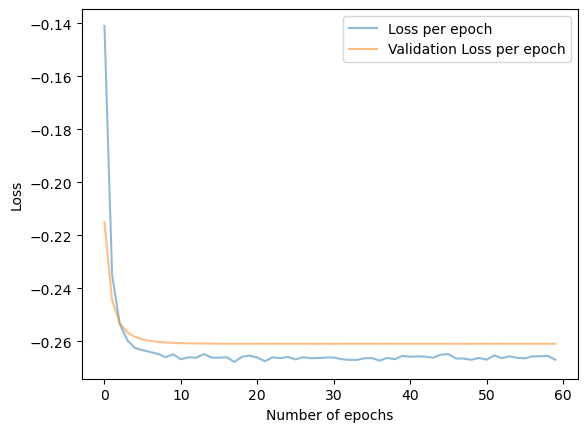

In [11]:
# Plot the loss 
#==============

# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['loss_per_batch'])), test_run_minibatch['loss_per_batch'], "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
# Compare model predictions
#============================#

p1 = logreg.predict_proba(df_test[ind_var_names])

test_train_dataset_orig = dcafs.SynthDataset(df_test, "y", None)

test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )

p2 = torch.sigmoid(test_run['net'](test_x).detach()).numpy()

p3 = torch.sigmoid(test_run_mnb['net'](test_x).detach()).numpy()

p2

array([[0.4956243 ],
       [0.20846298],
       [0.49759626],
       ...,
       [0.80008143],
       [0.82594573],
       [0.09940554]], dtype=float32)

Text(0, 0.5, 'numerical optimization')

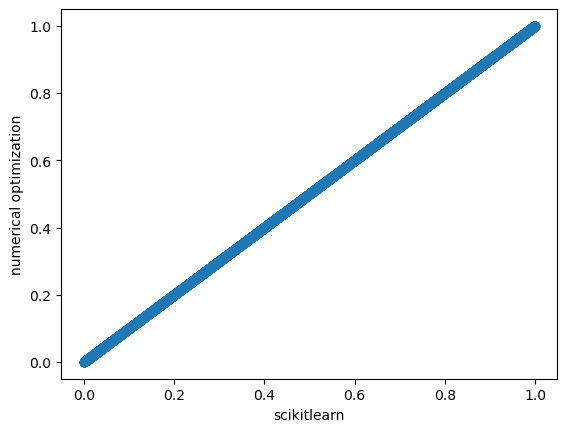

In [13]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p2)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'numerical optimization')

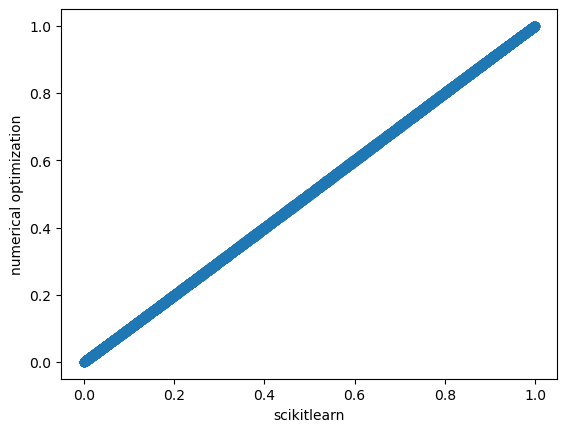

In [14]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p3)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'model log ods')

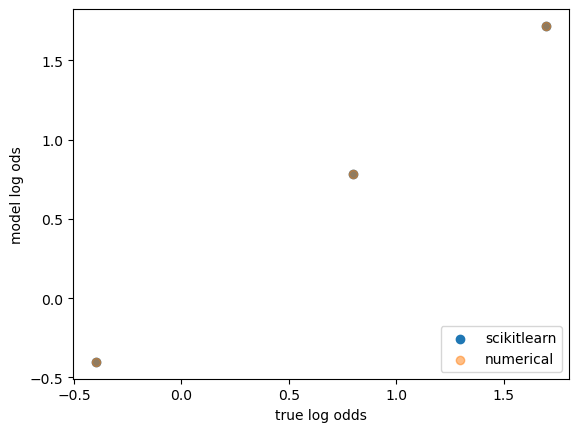

In [15]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

Text(0, 0.5, 'model log ods')

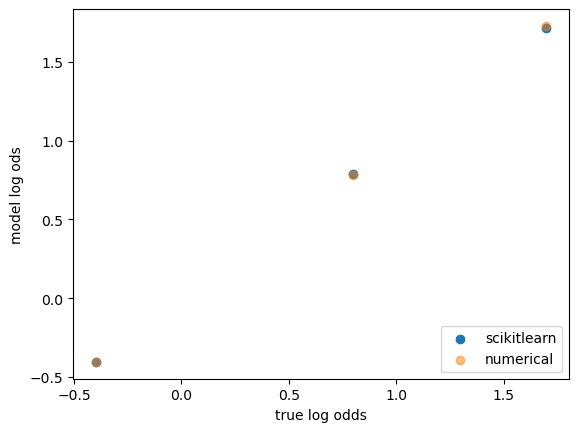

In [16]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run_mnb['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

In [4]:
#lr_boot(df_boot, df_test)

# Bootstrap distributions
# ========================= #

n_bootstraps = 3

skl_boot = []
torch_boot_log = []
torch_boot_mnb = []

for boot in range(n_bootstraps):
    #Make a bootstrap sample
    #-------------------------#
    df_boot = df_train.sample(frac=1, replace=True)

    #scikit learn
    #-------------
    skl_boot.append(dcat.lr_skl_boot(logreg, df_boot, df_test))

    # torch
    #-------
    torch_boot_log.append(dcat.lr_boot(df_boot, df_test, loss_fun="log"))

    # torch -mnb
    #-------
    torch_boot_mnb.append(dcat.lr_boot(df_boot, df_test, loss_fun="mnb"))

skl_boot = pd.concat(skl_boot, axis = 0).reset_index().drop("index", axis=1)
torch_boot_log = pd.concat(torch_boot_log, axis = 0).reset_index().drop("index", axis=1)
torch_boot_mnb = pd.concat(torch_boot_mnb, axis = 0).reset_index().drop("index", axis=1)



In [7]:
skl_boot

,label,auc,mnb,x0,x1,x2
0,scikit_learn,0.857387,0.265142,1.712491,0.809400,-0.402294
1,scikit_learn,0.857368,0.265101,1.710221,0.810138,-0.388793
2,scikit_learn,0.857386,0.265188,1.715821,0.808155,-0.410311


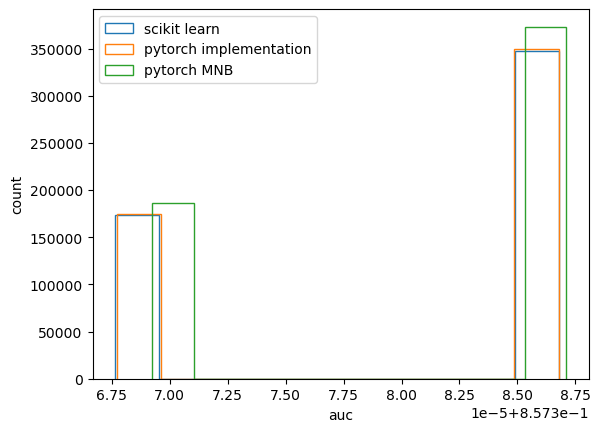

In [8]:
plt.hist(skl_boot["auc"],  label='scikit learn', histtype=u'step', density=True)
plt.hist(torch_boot_log["auc"], label='pytorch implementation', histtype=u'step', density=True)
plt.hist(torch_boot_mnb["auc"], label='pytorch MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()

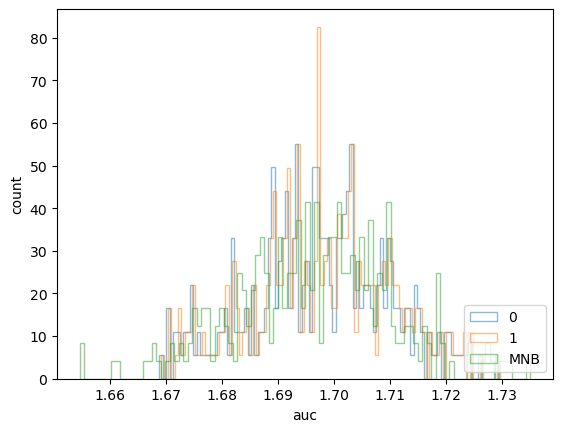

In [27]:
c = 0

plt.hist(coefs_skl[:, c], **kwargs, label='0', histtype=u'step', density=True)
plt.hist(coefs_torch[:, c], **kwargs, label='1',  histtype=u'step', density=True)
plt.hist(coefs_torch_mnb[:, c], **kwargs, label='MNB',  histtype=u'step', density=True)

plt.legend(loc='lower right')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()



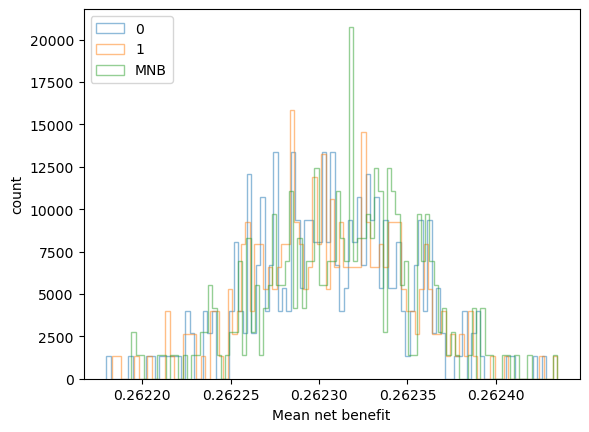

In [28]:
plt.hist(mnbs_skl, **kwargs, label='0', histtype=u'step', density=True)
plt.hist(mnbs_torch, **kwargs, label='1', histtype=u'step', density=True)
plt.hist(mnbs_torch_mnb, **kwargs, label='MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("Mean net benefit")
plt.ylabel("count")

plt.show()

## Test Torch LR with heteroskedasticity

### Agreement of LR parameters

In [4]:
# Create a dataset
#===================#
n_sample = 100000


df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    dcat.make_synth_data(n_features = 3, n_sample = n_sample, true_coefs = [1.7, 0.8, -0.4], true_bias=0.0, heteros=2.5) #, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])

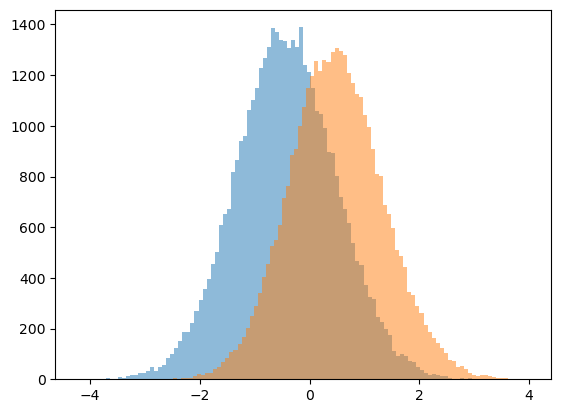

In [5]:
# Visualize synthetic data set
#================================#

x1 = df_train.loc[df_train.y==0]['x0']
x2 = df_train.loc[df_train.y==1]['x0']

kwargs = dict(alpha=0.5, bins=100)

plt.hist(x1, **kwargs, label='0')
plt.hist(x2, **kwargs, label='1')
plt.show()


#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.xlim(50,75)
#plt.legend();

In [6]:
# Fit a logistic regression with sklearn
#==========================================#

logreg.fit(df_train[ind_var_names], df_train["y"])

print(logreg.coef_)
#print(logreg.n_features_in_)

[[ 1.27909282  0.59963943 -0.29844828]]


In [7]:
# Fit with torch implementation
#================================#

test_run = dcafs.lr_train(df_train, n_epochs=1000, learn_rate=  1.0, loss_fun = 'log')
#test_run = lr_train(df_train, n_epochs=20000, learn_rate=  0.001, save_name_mod = "", loss_fun = 'mnb')

test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs

(Parameter containing:
 tensor([[ 1.2792,  0.5997, -0.2985]], requires_grad=True),
 Parameter containing:
 tensor([-0.1733], requires_grad=True),
 [1.7, 0.8, -0.4])

Parameter containing:
tensor([[ 1.2792,  0.5997, -0.2985]], requires_grad=True) Parameter containing:
tensor([-0.1733], requires_grad=True) [1.7, 0.8, -0.4]


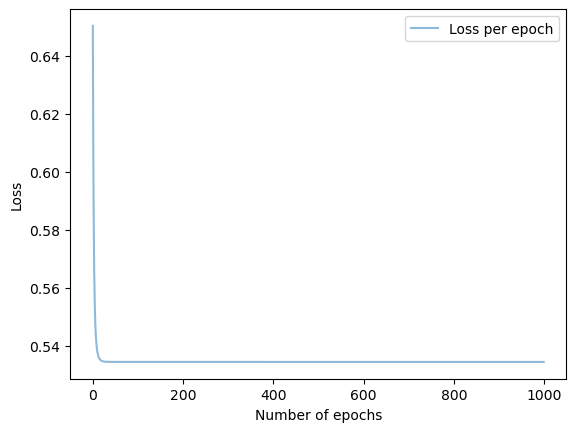

In [8]:
# Fit with torch implementation - mnb loss
#================================#

test_run_mnb = dcafs.lr_train(df_train, n_epochs=500, learn_rate=  1.0, loss_fun = 'mnb')
#test_run = reg_lr_train_legacy(df_train, n_epochs=100, learn_rate=  0.1, save_name_mod = "", loss_fun = 'mnb')

print(test_run['net'].linear.weight, test_run['net'].linear.bias, true_coefs)


# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run['loss'] )), test_run['loss'], "-", alpha=0.5, label="Loss per epoch")
#plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
# Fit with torch minibach implementation
#=======================================

#test_run_minibatch = lr_train_minibatch(df_train, n_epochs=30, batch_size = 10000, learn_rate=  1.0, save_name_mod = "", loss_fun = 'log')
test_run_minibatch = dcafs.lr_train_minibatch(df_train, n_epochs=60, batch_size = 10000, learn_rate=  1.0, loss_fun = 'mnb')

test_run_minibatch['model'].linear.weight, test_run_minibatch['model'].linear.bias, true_coefs

NameError: name 'lr_train_minibatch' is not defined

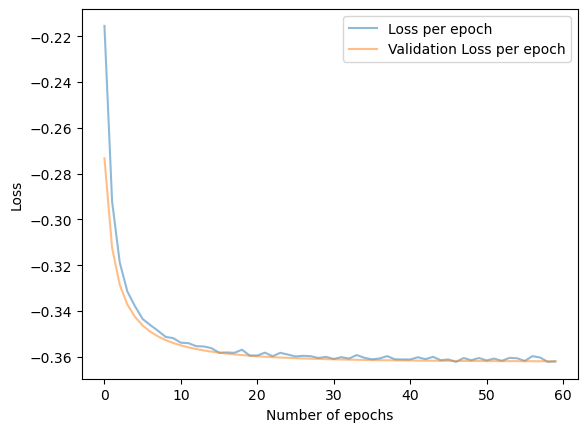

In [ ]:
# Plot the loss 
#==============

# plt.plot(np.arange(len(loss_per_iter)), loss_per_iter, "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['loss_per_batch'])), test_run_minibatch['loss_per_batch'], "-", alpha=0.5, label="Loss per epoch")
plt.plot(np.arange(len(test_run_minibatch['valid_loss_per_batch'])), test_run_minibatch['valid_loss_per_batch'], "-", alpha=0.5, label="Validation Loss per epoch")
#    #plt.plot(np.arange(len(loss_per_iter), step=4) + 3, loss_per_batch, ".-", label="Loss per mini-batch")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
# Compare model predictions
#============================#

p1 = logreg.predict_proba(df_test[ind_var_names])

test_train_dataset_orig = dcafs.SynthDataset(df_test, "y", None)

test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )

p2 = torch.sigmoid(test_run['net'](test_x).detach()).numpy()

p3 = torch.sigmoid(test_run_mnb['net'](test_x).detach()).numpy()

p2

array([[0.4670655 ],
       [0.76089317],
       [0.36899117],
       ...,
       [0.34950483],
       [0.83454686],
       [0.90053415]], dtype=float32)

Text(0, 0.5, 'numerical optimization')

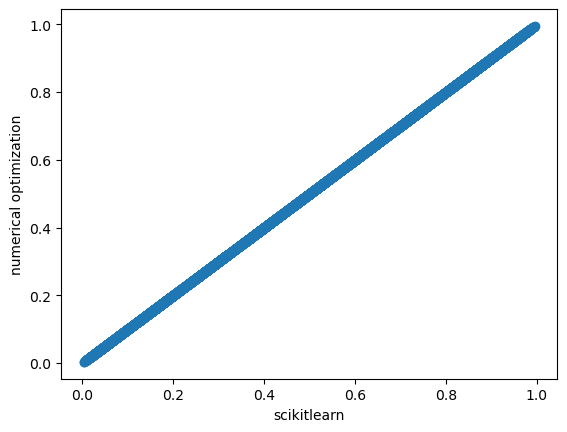

In [13]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p2)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'numerical optimization')

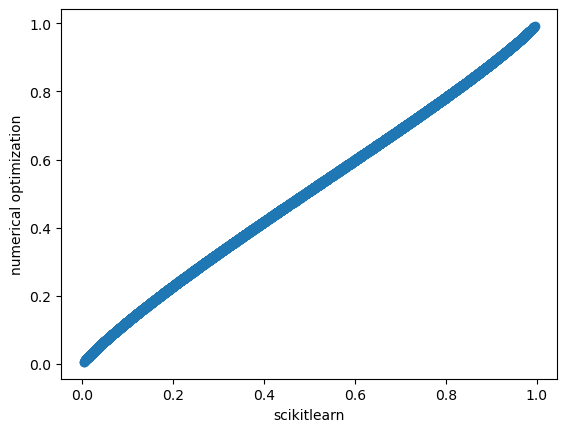

In [14]:
# Plot the comparison
#=======================#

plt.scatter(p1[:, 1], p3)
plt.xlabel("scikitlearn")
plt.ylabel("numerical optimization")

Text(0, 0.5, 'model log ods')

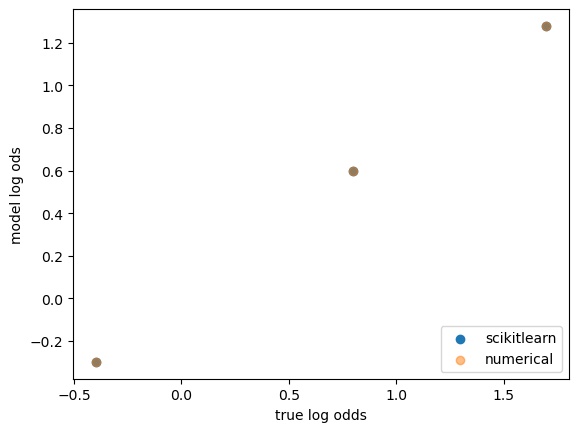

In [15]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

Text(0, 0.5, 'model log ods')

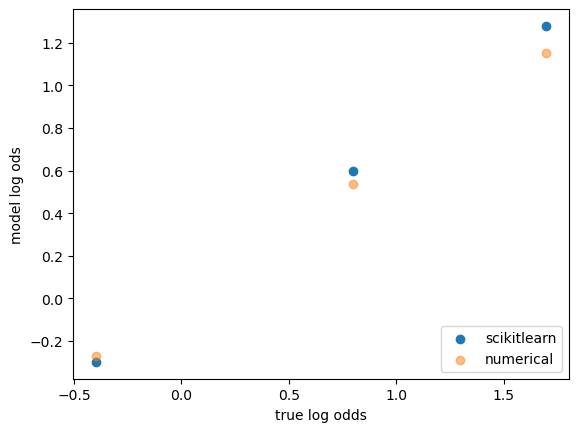

In [16]:
# Plot the comparison between the learned parameters
#====================================================#

param1 = logreg.coef_[0]
param2 = test_run_mnb['net'].linear.weight.detach().numpy()[0]

plt.scatter(true_coefs, param1, label = "scikitlearn")
plt.scatter(true_coefs, param2, label = "numerical", alpha=0.5)

plt.legend(loc='lower right')
plt.xlabel("true log odds")
plt.ylabel("model log ods")

In [18]:
# Bootstrap distributions
# ========================= #

n_bootstraps = 300

skl_boot = []
torch_boot_log = []
torch_boot_mnb = []

for boot in range(n_bootstraps):
    #Make a bootstrap sample
    #-------------------------#
    df_boot = df_train.sample(frac=1, replace=True)

    #scikit learn
    #-------------
    skl_boot.append(dcat.lr_skl_boot(logreg, df_boot, df_test))

    # torch
    #-------
    torch_boot_log.append(dcat.lr_boot(df_boot, df_test, loss_fun="log"))

    # torch -mnb
    #-------
    torch_boot_mnb.append(dcat.lr_boot(df_boot, df_test, loss_fun="mnb"))

skl_boot = pd.concat(skl_boot, axis = 0).reset_index().drop("index", axis=1)
torch_boot_log = pd.concat(torch_boot_log, axis = 0).reset_index().drop("index", axis=1)
torch_boot_mnb = pd.concat(torch_boot_mnb, axis = 0).reset_index().drop("index", axis=1)



In [19]:
plt.hist(aucs_skl, **kwargs, label='scikit learn', histtype=u'step', density=True)
plt.hist(aucs_torch, **kwargs, label='pytorch implementation', histtype=u'step', density=True)
plt.hist(aucs_torch_mnb, **kwargs, label='pytorch MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()

NameError: name 'aucs_skl' is not defined

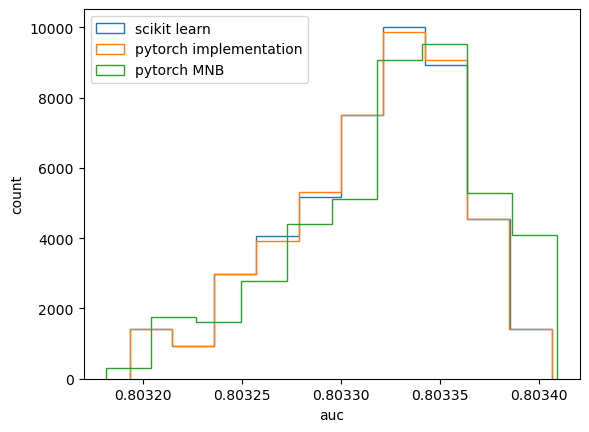

In [20]:
plt.hist(skl_boot["auc"],  label='scikit learn', histtype=u'step', density=True)
plt.hist(torch_boot_log["auc"], label='pytorch implementation', histtype=u'step', density=True)
plt.hist(torch_boot_mnb["auc"], label='pytorch MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()


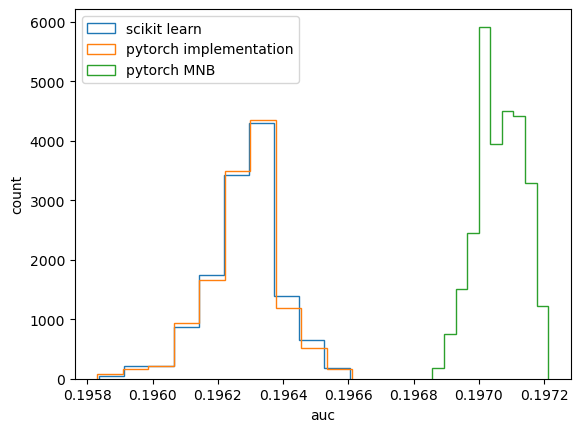

In [21]:
plt.hist(skl_boot["mnb"],  label='scikit learn', histtype=u'step', density=True)
plt.hist(torch_boot_log["mnb"], label='pytorch implementation', histtype=u'step', density=True)
plt.hist(torch_boot_mnb["mnb"], label='pytorch MNB', histtype=u'step', density=True)

plt.legend(loc='upper left')
plt.xlabel("auc")
plt.ylabel("count")

plt.show()

### Test L1 regularization path

In [3]:
# Create a dataset
#===================#

n_sample = 10000
df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    dcat.make_synth_data(n_features = 5, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5])# , 1.2, 0.8, 0.5, -0.2,0.1])

In [4]:
cs = l1_min_c(df_train[ind_var_names], df_train["y"], loss="log") * np.logspace(0, 5, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_train[ind_var_names], df_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

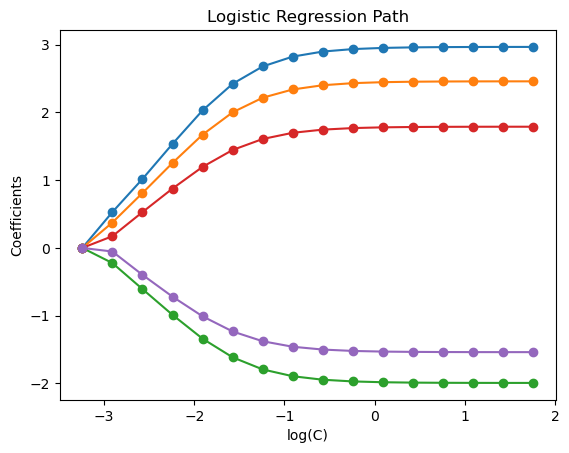

In [5]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [6]:
#coefs_.shape
#np.logspace(10, 0, 16)
#np.logspace(0, 10, 16)

df_train.shape[0]

sum([1,2,3])

6

In [ ]:

""" 
def reg_path(
        df_train,
        df_test,
        dependent = "y",
        independent_in = None,
        test_harms = None,

        n_epochs = 10000,
        learn_rate = 1.0,
        loss_fun = "log",

        regularization_type = 'L1',

        log_space_min = 0,
        log_space_max = 5,
        log_space_steps = 16,

        label = "reg_path"
):
        if independent_in == None:
            independent = list(df_train.drop([dependent], axis=1).columns)
        else:
            independent = independent_in
            
        cs = l1_min_c(df_train[independent], df_train[dependent], loss=loss_fun) * np.logspace(log_space_max, log_space_min, log_space_steps)

        if test_harms == None:
             test_harms = [0. for i in independent]
        

        n_sample = df_train.shape[0]

        test_reg_path = {}
        path_df = []

        start_model = dcafs.lr_train(df_train, n_epochs=n_epochs, learn_rate=learn_rate, loss_fun = loss_fun)['net']

        test_train_dataset_orig = dcafs.SynthDataset(df_test, dependent, independent)
        test_x = torch.from_numpy(test_train_dataset_orig.x.to_numpy().astype(np.float32) )

        total_harm = sum(test_harms)
        if total_harm > 0:
             l1_weights = test_harms/sum(test_harms)
        else:
             l1_weights = [1. for i in test_harms]
             

        for i, inv_lambda_reg in enumerate(cs):
            print(i)
            print("lambda")
            print(1./inv_lambda_reg)
            lda = 1./(inv_lambda_reg)
            lda = lda/n_sample
             
            new_model = \
                        dcafs.reg_lr_train(df_train, 
                                   net = start_model, 
                                   n_epochs=n_epochs, 
                                   learn_rate = learn_rate, 
                                   loss_fun = loss_fun, 
                                   regularization_type = regularization_type, 
                                   weights = l1_weights, 
                                   lambda_reg=lda)
            # Calculate the net benefit accounting for test harm
            pred = torch.sigmoid(new_model["net"](test_x )).detach().numpy()

            # mean net benefit with no test harm
            mnb0 = dcat.mean_net_benefit(df_test['y'], pred, n_thresh=100)['mnb'] 

            # Calculate the test harm
            coefs = new_model["net"].linear.weight.detach().numpy()
            coefs_used = [np.heaviside(i, 0.) for i in abs(coefs[0])]

            n_coefs = len([i for i in coefs_used if i>0])

            harm = dcafs.mydot(coefs_used, test_harms)

                
            

            coefs_df = pd.DataFrame(new_model["net"].linear.weight.detach().numpy(), columns=independent)
            coefs_used_df = pd.DataFrame([coefs_used], columns = [i+"_used" for i in independent])

            out = pd.DataFrame({
                    "label": [label],
                    "mnb0" : [mnb0],
                    "harm" : [harm],
                    "mnb": [mnb0-harm],
                    "n_coefs": [n_coefs]
                })
                
            out = pd.concat([out, coefs_df, coefs_used_df], axis=1)
            path_df.append(out)

            #-----------------#
            test_reg_path[i] = copy.deepcopy(new_model['net'])
            start_model = copy.deepcopy(new_model['net'])
        
        path_df = pd.concat(path_df, axis=0).reset_index().drop("index", axis=1)

        return {"models": test_reg_path, "path": path_df} """

test = dcafs.reg_path(df_train, df_test)


0
lambda
0.01745137918418394
1
lambda
0.03759785670330617
2
lambda
0.0810021267524507
3
lambda
0.17451379184183938
4
lambda
0.3759785670330617


In [11]:
test["path"]

,label,mnb0,harm,mnb,n_coefs,x0,x1,x2,x3,x4,x0_used,x1_used,x2_used,x3_used,x4_used
0,reg_path,0.370343,0.0,0.370343,5,2.993917,2.510575e+00,-2.074350,1.755372,-1.483404,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370343,0.0,0.370343,5,2.993917,2.510575e+00,-2.074350,1.755372,-1.483404,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370343,0.0,0.370343,5,2.993917,2.510575e+00,-2.074350,1.755372,-1.483404,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370343,0.0,0.370343,5,2.993917,2.510575e+00,-2.074350,1.755372,-1.483404,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370343,0.0,0.370343,5,2.993917,2.510575e+00,-2.074350,1.755372,-1.483404,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370189,0.0,0.370189,5,2.978259,2.497022e+00,-2.063025,1.745412,-1.474781,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370046,0.0,0.370046,5,2.960376,2.481543e+00,-2.050180,1.734142,-1.464889,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370586,0.0,0.370586,5,2.922779,2.449069e+00,-2.023236,1.710500,-1.444146,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370774,0.0,0.370774,5,2.846051,2.382741e+00,-1.968068,1.662040,-1.401746,1.0,1.0,1.0,1.0,1.0
0,reg_path,0.370320,0.0,0.370320,5,2.697377,2.254344e+00,-1.861175,1.568077,-1.319451,1.0,1.0,1.0,1.0,1.0


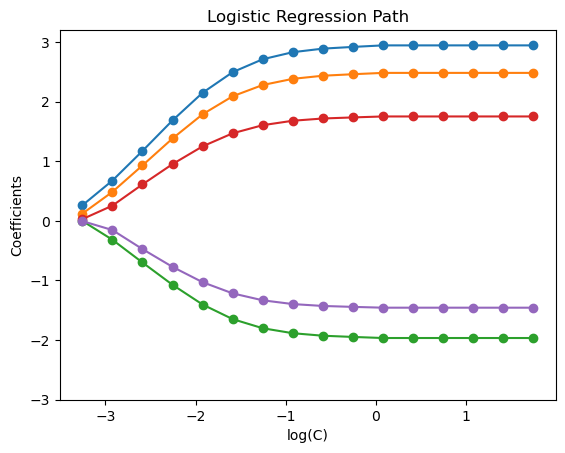

In [82]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.ylim(-3.,3.2)
plt.show()

#### Examine the efect of noisey features

In [ ]:
# Create a dataset
#===================#

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])
n_sample = 10000
df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 5, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5], noise = [10.0, 0.0, 0.0, 3.0, 10.0])

In [99]:
cs = l1_min_c(df_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(0, 10, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_noisy_train[ind_var_names], df_noisy_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

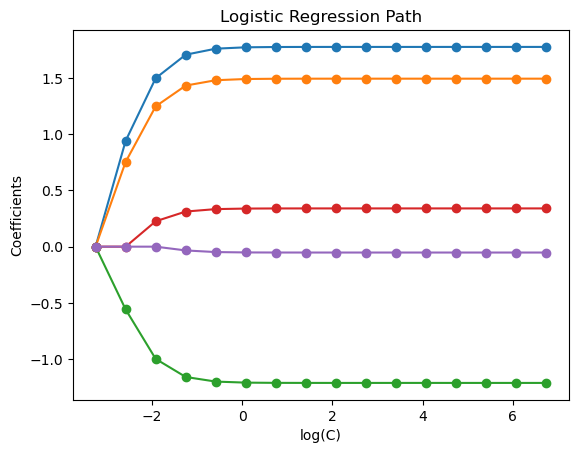

In [100]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [54]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(10, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'log')['net']


#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'log', 
                 regularization_type = 'L1', 
                 weights = [1.0, 1.0, 1.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
1.8002222697886293e-07
1
lambda
8.355891585471941e-07
2
lambda
3.8784613078005644e-06
3
lambda
1.8002222697886294e-05
4
lambda
8.355891585471942e-05
5
lambda
0.0003878461307800557
6
lambda
0.0018002222697886291
7
lambda
0.008355891585471942
8
lambda
0.03878461307800557
9
lambda
0.18002222697886291
10
lambda
0.8355891585471942
11
lambda
3.878461307800557
12
lambda
18.002222697886292
13
lambda
83.55891585471942
14
lambda
387.8461307800549
15
lambda
1800.2222697886293


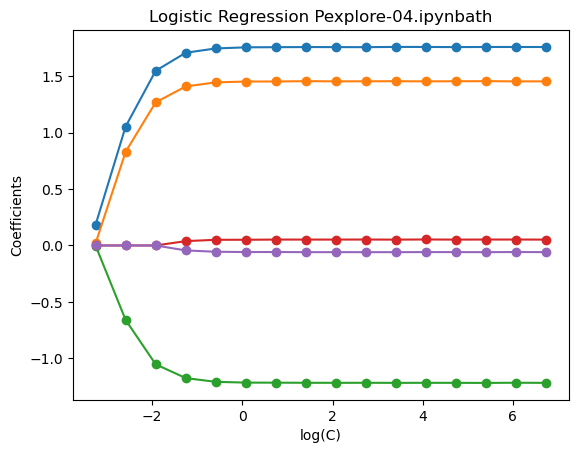

In [55]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()

## Weighted Lasso

In [27]:
# Create a dataset
#===================#

#make_synth_data(n_features = 10, n_sample = 100000, true_coefs = [3, 2.5, -2.0, 1.8, -1.5, 1.2, 0.8, 0.5, -0.2,0.1])
#make_synth_data(n_features = 3, n_sample = 100000, true_coefs = [ 3,2,1 ])
n_sample = 10000
df_train, df_test, df_noisy_train, df_noisy_test, ind_var_names, n_features, true_coefs = \
    make_synth_data(n_features = 5, n_sample = n_sample, true_coefs = [3, 2.5, -2.0, 1.8, -1.5], noise = [0.0, 0.0, 0.0, 0.0, 0.0])

In [47]:
n_sample = 1000

df_noisy_train, df_noisy_test, ind_var_names = make_class_dataset(n_sample = n_sample,
                                       n_features = 10,
                                       n_redundant = 2,
                                       random_state = 2001,
                                       n_informative = 8,
                                       n_clusters_per_class = 1,
                                       n_classes = 2)







In [29]:
df_noisy_train

,y,x0,x1,x2,x3,x4
281,0,-0.850895,-0.489947,-0.700438,0.357020,-0.459897
42,1,0.540062,0.647582,-1.066479,-0.671953,-0.696882
255,0,1.014804,-0.135872,-1.548579,0.528999,-1.331191
906,0,1.129083,0.963220,0.494918,-1.057438,0.538993
394,1,0.346342,-0.068678,-0.604576,-0.974772,0.969433
...,...,...,...,...,...,...
204,1,0.841249,1.175517,1.080256,0.511380,0.349745
53,0,1.554227,0.675740,0.528742,-0.618703,0.532519
294,1,-0.046100,1.112928,0.036328,-0.336101,-0.151528
723,0,-0.359434,-1.303079,-0.487219,1.257909,-0.099846


In [48]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(0, 5, 16)

clf = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    tol=1e-6,
    max_iter=int(1e6),
    warm_start=True,
    intercept_scaling=10000.0,
)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(df_noisy_train[ind_var_names], df_noisy_train["y"] )
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)

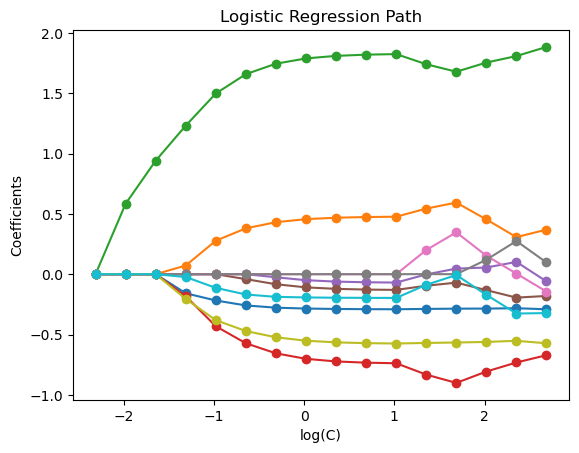

In [49]:
plt.plot(np.log10(cs), coefs_, marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Path")
plt.axis("tight")
plt.show()

In [50]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'log')['net']


#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'log', 
                 regularization_type = 'L1', 
                 weights = [1.0, 1.0, 1.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
0.0020548749178350596
1
lambda
0.0044270938066602655
2
lambda
0.009537884473094194
3
lambda
0.020548749178350593
4
lambda
0.044270938066602664
5
lambda
0.09537884473094184
6
lambda
0.20548749178350595
7
lambda
0.4427093806660266
8
lambda
0.9537884473094184
9
lambda
2.0548749178350594
10
lambda
4.427093806660266
11
lambda
9.537884473094184
12
lambda
20.548749178350594
13
lambda
44.27093806660266
14
lambda
95.37884473094176
15
lambda
205.48749178350596


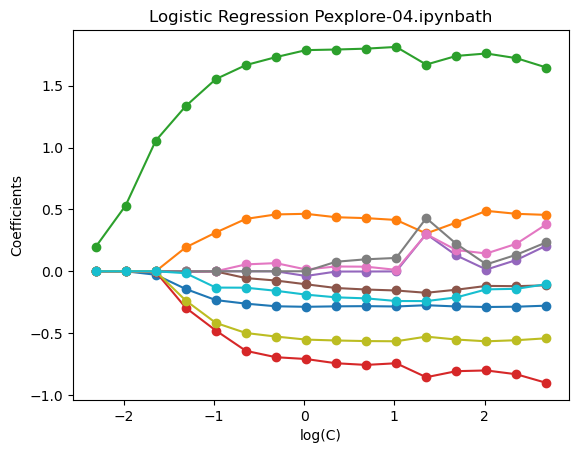

In [51]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()

In [52]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'mnb')['net']

#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'mnb', 
                 regularization_type = 'L1', 
                 weights = [1.0, 1.0, 1.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
0.0020548749178350596
1
lambda
0.0044270938066602655
2
lambda
0.009537884473094194
3
lambda
0.020548749178350593
4
lambda
0.044270938066602664
5
lambda
0.09537884473094184
6
lambda
0.20548749178350595
7
lambda
0.4427093806660266
8
lambda
0.9537884473094184
9
lambda
2.0548749178350594
10
lambda
4.427093806660266
11
lambda
9.537884473094184
12
lambda
20.548749178350594
13
lambda
44.27093806660266
14
lambda
95.37884473094176
15
lambda
205.48749178350596


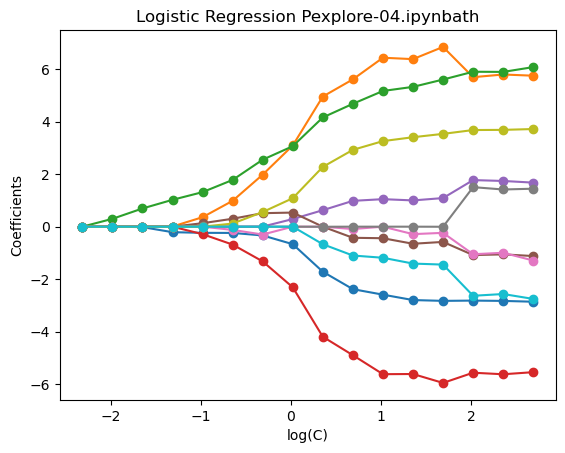

In [53]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()

In [54]:
cs = l1_min_c(df_noisy_train[ind_var_names], df_noisy_train["y"], loss="log") * np.logspace(5, 0, 16)

#cs = cs[0:8]
test_reg_path = {}

start_model = lr_train(df_noisy_train, n_epochs=10000, learn_rate=  1.0, loss_fun = 'mnb')['net']


#history_size = 100, 
#max_iter = 20, 
#tolerance_grad=1e-07, 
#tolerance_change=1e-09,

for i, inv_lambda_reg in enumerate(cs):
    print(i)
    #fm = reg_lr_train(df_train, n_epochs=1000, learn_rate = 1.0, save_name_mod = "", loss_fun = 'log', regularization_type = 'L1', weights = [1.0, 1.0, 1.0])
    print("lambda")
    print(1./inv_lambda_reg)
    lda = 1./(inv_lambda_reg)
    lda = lda/n_sample
    #lda = lda/ n_features
    new_model = \
    reg_lr_train(df_noisy_train, 
                 n_epochs=1000, 
                 learn_rate = 0.01,
                 history_size= 100,
                 max_iter= 100,
                 tolerance_grad=1e-8,
                 tolerance_change=1e-10,
                 loss_fun = 'mnb', 
                 regularization_type = 'weighted_L1', 
                 weights = [1.0, 100.0, 1.0, 1.0, 10.0], 
                 lambda_reg=lda )

    test_reg_path[i] = copy.deepcopy(new_model['net'])

    start_model = copy.deepcopy(new_model['net'])


coefs_num = []

for i in test_reg_path.keys():
    coefs_num.append(test_reg_path[i].linear.weight.detach().numpy()[0])

coefs_num = np.vstack(coefs_num)

0
lambda
0.0020548749178350596


RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 1

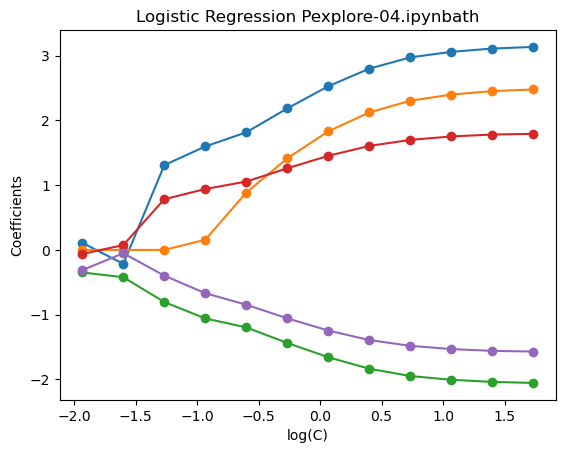

In [ ]:
plt.plot(np.log10(cs[:]), coefs_num[:, :], marker="o")
ymin, ymax = plt.ylim()
plt.xlabel("log(C)")
plt.ylabel("Coefficients")
plt.title("Logistic Regression Pexplore-04.ipynbath")
plt.axis("tight")
#plt.ylim(-3.,3.2)
plt.show()